## Lectura de Datos

In [1]:
import pickle, gzip, scipy
from scipy import special
import numpy as np
import time
import matplotlib.pyplot as plt

# Importo función signmoide
sigmoid = special.expit

In [2]:
dir = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T05/mnist.pkl.gz'
with gzip.open(dir, 'rb') as f:
	u = pickle._Unpickler(f)
	u.encoding = 'latin1'
	train_set, val_set, test_set = u.load()

In [3]:
print('train set :', train_set[0].shape, 'train_set_labels:', train_set[1].shape)
print('val set   :', val_set[0].shape, 'val_set_labels  :'  , train_set[1].shape)
print('test set  :', test_set[0].shape, 'test_set_labels :' , test_set[1].shape)

train set : (50000, 784) train_set_labels: (50000,)
val set   : (10000, 784) val_set_labels  : (50000,)
test set  : (10000, 784) test_set_labels : (10000,)


#### Ejemplo

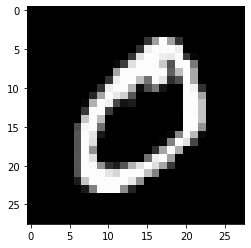

Classification :  0


In [4]:
idx = 1
im = train_set[0][idx].reshape(28, -1)
plt.imshow(im, 'gray')
plt.show()

print('Classification : ', train_set[1][idx])

## Carga datos cero y uno

In [5]:
def get_data_cero_one(data, c1 = 0, c2 = 1, normalize = False) :
  '''
  Extrae los datos para el modelo
  Parámetros
  -----------
    data      : Conjunto de datos con etiquetas
    c1        : Clase uno
    c2        : clase dos
    normalize : Booleano para normalización por filas
  Regresa
  -----------
    x         : Matriz de vectores de entrenamiento
    y         : Etiquetas de entrenamiento
  '''
  index = np.logical_or(data[1] == c1, data[1] == c2)
  x = data[0][index]
  y = data[1][index]

  if normalize :
    x /= np.linalg.norm(x, axis = 1)[:, None]
  return x, y

In [6]:
x_train, y_train = get_data_cero_one(train_set)
x_val, y_val     = get_data_cero_one(val_set)
x_test, y_test   = get_data_cero_one(test_set)

In [7]:
print('train set :', x_train.shape, 'train_set_labels:', y_train.shape)
print('val set   :', x_val.shape, ' val_set_labels  :', x_val.shape)
print('test set  :', x_test.shape, ' test_set_labels :', x_test.shape)

train set : (10610, 784) train_set_labels: (10610,)
val set   : (2055, 784)  val_set_labels  : (2055, 784)
test set  : (2115, 784)  test_set_labels : (2115, 784)


# Función a Optimizar

In [8]:
def get_g(x, c, d) :
  '''
  Calcula vector de valores [\sigma(c_j^T x + d_j)]_{j=1}^m
  Parámetros
  -----------
    x : Punto a evaluar         n x 1
    c : matrix de vectores c_j  m x n
    d : vector de escalares d   m x 1
  Regresa
  -----------
    g  : vector de valores      m x 1               
  '''
  g = c @ x + d
  g = sigmoid(g)            

  return np.array(g)

In [9]:
def get_h(x, a, b, c, d) :
  '''
  Calcula vector de valores [h(x_0), h(x_1), ..., h(x_N)]
  Parámetros
  -----------
    x : matriz con vectores x_i    N x n
    a : vector de pesos            m x 1
    b : bias de f                  1 x 1
    c : matrix de vectores c_j     m x n
    d : vector de escalares d      m x 1
  Regresa
  -----------
    vector de valores [h(x_0), h(x_1), ..., h(x_N)]
  ''' 
  g = np.array([c.dot(x_i) + d for x_i in x])
  g = sigmoid(g)
  h = g.dot(a) + b
  h = sigmoid(h)

  return np.array(h)

In [10]:
def F(theta, params) :
  '''
  Calcula valor F(\theta)
  Parámetros
  -----------
    theta : vector concatenado de valores [a, b, c_1, ..., c_m, d
  Regresa
  -----------
    valor de la función F(\theta)
  '''
  # Obtengo parámetros de función
  n = params['n']
  m = params['m']
  N = params['N']
  # Divido vector de valores
  a = theta[:m]
  b = theta[m]
  c = np.reshape(theta[m + 1 : n*m + (m+1)], (m,n))
  d = theta[n*m + (m+1):]
  # Obtengo valores de h_i
  h = get_h(params['x'], a, b, c, d)
  # Sumo valores y obtengo F
  F = np.sum((h - params['y'])**2) / N

  return F

In [11]:
def canonical(position = 0, shape = 1000) :
  e_i           = np.zeros(shape, dtype = np.float32)
  e_i[position] = 1.0
  return e_i

In [12]:
def F_grad_aprox(theta, params = {}) :
  h     = params['h']
  size  = theta.shape[0]
  # Obtengo F(theta)
  F_val  = F(theta, params)
  # obtengo x + h e_i
  values = [theta + h * canonical(position = i, shape = size) for i in range(size)]
  values = np.array(values)
  
  grad = np.apply_along_axis(F, 1, values, params) 
  grad = (grad - F_val) / h

  return grad

In [13]:
def Hd_aprox(theta, d, g_k, params = {}) :
  h     = params['h']
  g_x_h = F_grad_aprox(theta + h * d, params)

  Hd = (g_x_h - g_k) / h

  return np.array(Hd)

# Descenso Gradiente

In [14]:
def back_tracking (x_k, d_k, f, f_grad, alpha = 0.1, ro = 0.9, c1 = 1e-4, params = {}, max_iter = 20) :
  '''
  Calcula tamaño de paso alpha
    Parámetros
    -----------
      x_k     : Vector de valores [x_1, x_2, ..., x_n]
      d_k     : Dirección de descenso
      f       : Función f(x)
      f_grad  : Función que calcula gradiente
      alpha   : Tamaño inicial de paso
      ro      : Ponderación de actualización
      c1      : Condición de Armijo
    Regresa
    -----------
      alpha_k : Tamaño actualizado de paso
    '''
  # Inicialización
  alpha_k = alpha

  # Repetir hasta que se cumpla la condición de armijo
  i = 0
  while f(x_k + alpha_k * d_k, params) > f(x_k, params) + c1 * alpha_k * f_grad(x_k, params).dot(d_k) :
    alpha_k = ro * alpha_k
    
    i += 1
    if i > max_iter :
      break
        
  return alpha_k

In [33]:
# Descenso Gradiente
def des_grad (params = []) :
  # Cargo parámetros
  x_k        = params['x_0']
  x_k_next   = None
    
  f          = params['f']
  f_grad     = params['f_grad']
  max_iter   = params['max_iter']
  tau_f_grad = params['tau_grad']
    
  # Identifico parámetros especiales
  sub_params = params['f_params']
        
  # Guardo Parámetros
  f_hist = []
  # f_hist.append(f(x_k, params = sub_params))

  g_hist = []
  # g_hist.append(np.linalg.norm(f_grad(x_k, params = sub_params)))
              
  # Comienza descenso
  k = 0 
  while True:
    # Calculo gradiente
    g_k = f_grad(x_k, params = sub_params)
    d_k = - g_k
    # Cálculo tamaño de paso
    Hd = Hd_aprox(x_k, d_k, g_k, sub_params)
    alpha_k = - g_k.dot(d_k) / d_k.T.dot(Hd)
    # Calculo siguiente valor x_k+1
    x_k_next = x_k + alpha_k * d_k   
        
    # Guardo Parámetros
    f_hist.append(f(x_k_next, sub_params))
    g_hist.append(np.linalg.norm(d_k))

    # Criterios de paro
    if (k > max_iter) :
      print('Iteraciones: ', k, ' , valor: ', x_k)
      break       
    if np.linalg.norm(g_hist[-1]) < tau_f_grad :
      print('Iteraciones: ', k, ' , valor: ', x_k)
      break
            
    # Guardo valor anterior   
    x_k = x_k_next       
    k   = k + 1
    print('iteración: ', k, 'Norma de gradiente: ', g_hist[-1])
        
  return np.array(f_hist), np.array(g_hist), x_k_next

# BFGS

In [17]:
def get_B_k(B_k, y_k, s_k) :
  I    = np.identity(s_k.shape[0])
  ro_k = 1.0 / s_k.dot(y_k)
  ML   = (I - ro_k * np.outer(s_k, y_k))
  MR   = (I - ro_k * np.outer(y_k, s_k)) 
        
  return  (ML @ B_k @ MR) + ro_k * np.outer(s_k, s_k)

In [18]:
def BFGS (params = []) :
  # Cargo parámetros
  x_k        = params['x_0']
  x_k_next   = None
  B_k        = params['B_0']

  f          = params['f']
  f_grad     = params['f_grad']
  max_iter   = params['max_iter']
  tau_f_grad = params['tau_grad']
    
  # Identifico parámetros especiales
  sub_params = params['f_params']

  if (params['method'] == 'BackTracking') :
    alpha = params['BackTracking']['alpha']
    ro    = params['BackTracking']['ro']
    c1    = params['BackTracking']['c1']
        
  # Guardo Parámetros
  f_hist = []
  f_hist.append(f(x_k, params = sub_params))

  g_hist = []
  g_k = f_grad(x_k, params = sub_params)
  g_hist.append(np.linalg.norm(g_k))
              
  # Comienza iteración
  k = 0 
  while True:
    # Calculo gradiente
    d_k = - B_k.dot(g_k) 
    # Cálculo tamaño de paso
    alpha_k = back_tracking(x_k, d_k, f, f_grad, alpha, ro, c1, params = sub_params)
    # Calculo siguiente valor x_k+1
    x_k_next = x_k + alpha_k * d_k 
    # Calculo grad(f_{k+1})
    g_k_next = f_grad(x_k_next, sub_params)  
    # Actualizo y_k, s_k y \ro_k
    y_k     = g_k_next - g_k
    s_k     = x_k_next - x_k

    B_k = get_B_k(B_k, y_k, s_k)

    # Guardo Parámetros
    f_hist.append(f(x_k_next, sub_params))
    g_hist.append(np.linalg.norm(g_k))

    # Criterios de paro
    if k > max_iter :
      print('Iteraciones: ', k, ' , valor: ', x_k)
      break       
    if np.linalg.norm(g_hist[-1]) < tau_f_grad :
      print('Iteraciones: ', k, ' , valor: ', x_k)
      break
            
    # Guardo valor anterior   
    x_k = x_k_next 
    g_k = g_k_next      
    k   = k + 1
    print('iteración: ', k, 'Norma de gradiente: ', g_hist[-1])
        
  return np.array(f_hist), np.array(g_hist), x_k_next

# Gráficas

In [16]:
def get_graf(f_hist, g_hist) :    
  plt.plot(range(f_hist.shape[0]), f_hist) 
  # naming the x axis 
  plt.xlabel('k') 
  # naming the y axis 
  plt.ylabel('f_k') 
  # giving a title to my graph 
  plt.title('Iteration vs Fuction Value') 
  # function to show the plot 
  plt.show() 
  plt.plot(range(g_hist.shape[0]), g_hist) 
  # naming the x axis 
  plt.xlabel('k') 
  # naming the y axis 
  plt.ylabel('g_k') 
  # giving a title to my graph 
  plt.title('Iteration vs Gradient Norm') 
  # function to show the plot 
  plt.show() 

# Prueba

In [ ]:
N = x_train.shape[0]
n = x_train.shape[1]
m = 2

a = np.ones(m, dtype = np.float32)
b = [1.0]
c = np.ones((m*n), dtype = np.float32)
d = np.ones(m, dtype = np.float32)

a.shape, 1, c.shape, d.shape

((2,), 1, (1568,), (2,))

In [ ]:
theta = np.concatenate((a,b,c,d))

In [ ]:
params = {'x' : x_train,
          'y' : y_train,
          'N' : N, 
          'n' : n, 
          'm' : m,
          'h' : 1e-4
         }

In [ ]:
star = time.time()
f = F(theta, params)
print('time: ', time.time() - star)

time:  0.04534721374511719


In [ ]:
star = time.time()
g = F_grad_aprox(theta, params = params)
print('time: ', time.time() - star)

time:  107.451336145401


In [ ]:
star = time.time()
g = F_grad_aprox(theta, h = 1e-4, params = params)
print('time: ', time.time() - star)

time:  81.13475131988525


# m = 2

In [19]:
N = x_train.shape[0]
n = x_train.shape[1]
m = 2

In [20]:
a = np.random.normal(size = m)
b = [1.0]
c = np.random.normal(size = m*n)
d = np.random.normal(size = m)

a.shape, 1, c.shape, d.shape

((2,), 1, (1568,), (2,))

In [21]:
theta = np.concatenate((a,b,c,d))

## Descenso Gradiente

iteración:  1 Norma de gradiente:  0.061839800185186054
iteración:  2 Norma de gradiente:  0.08064635607968682
iteración:  3 Norma de gradiente:  0.018034038277324232
iteración:  4 Norma de gradiente:  0.011800937196636448
iteración:  5 Norma de gradiente:  0.010280486121637915
iteración:  6 Norma de gradiente:  0.015688535700904258
iteración:  7 Norma de gradiente:  0.020846174575845516
iteración:  8 Norma de gradiente:  0.04140517728179985
iteración:  9 Norma de gradiente:  0.043132288385008696
iteración:  10 Norma de gradiente:  0.08663464065756185
iteración:  11 Norma de gradiente:  0.05907770817826846
iteración:  12 Norma de gradiente:  0.10817884087064379
iteración:  13 Norma de gradiente:  0.05260334699967127
iteración:  14 Norma de gradiente:  0.07969195709038127
iteración:  15 Norma de gradiente:  0.02675763750662082
iteración:  16 Norma de gradiente:  0.011490245074129575
iteración:  17 Norma de gradiente:  0.010806751326592527
Iteraciones:  17  , valor:  [ 5.03566913  1.1893

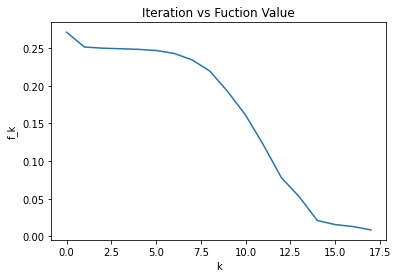

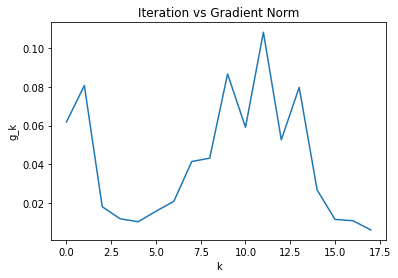

In [ ]:
params = {'x_0'      : theta,
          'f'        : F,
          'f_grad'   : F_grad_aprox,
          'x'        : x_train,
          'y'        : y_train,
          'max_iter' : 30,
          'tau_grad' : 1e-2,
          'f_params' : {'x' : x_train,
                        'y' : y_train,
                        'N' : N, 
                        'n' : n, 
                        'm' : m,
                        'h' : 1e-4
                       }
          }

star = time.time()
f_hist, g_hist, x_star_sd = des_grad(params)
print ('Tiempo de ejecución: ', time.time() - star, 'segundos.')
get_graf(f_hist, g_hist)

## BFGS

In [22]:
from sklearn.datasets import make_spd_matrix
from sklearn.preprocessing import normalize

# Genero matriz definida positiva
H_0 = make_spd_matrix(theta.shape[0])

iteración:  1 Norma de gradiente:  0.07308061988416446
iteración:  2 Norma de gradiente:  0.04989815309593691
iteración:  3 Norma de gradiente:  0.030376067944380993
iteración:  4 Norma de gradiente:  0.022763592857315218
iteración:  5 Norma de gradiente:  0.019900890314478226
iteración:  6 Norma de gradiente:  0.01931198524279767
iteración:  7 Norma de gradiente:  0.021097268077556363
iteración:  8 Norma de gradiente:  0.02624891013297483
iteración:  9 Norma de gradiente:  0.03531245636349689
iteración:  10 Norma de gradiente:  0.04846292719621009
iteración:  11 Norma de gradiente:  0.06613697565724763
iteración:  12 Norma de gradiente:  0.08110387024852432
iteración:  13 Norma de gradiente:  0.08275380164010028
iteración:  14 Norma de gradiente:  0.0724852658839351
iteración:  15 Norma de gradiente:  0.05875688890704634
iteración:  16 Norma de gradiente:  0.0601076656566216
iteración:  17 Norma de gradiente:  0.0688486057951687
iteración:  18 Norma de gradiente:  0.07970489900547177


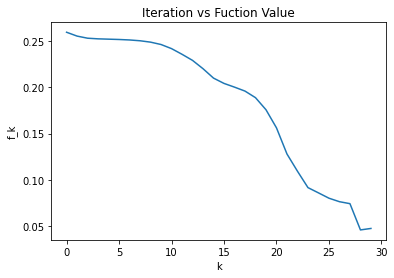

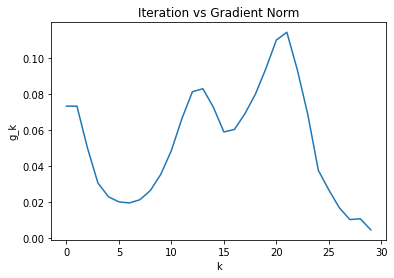

In [23]:
params = {'x_0'      : theta,
          'B_0'      : H_0,
          'f'        : F,
          'f_grad'   : F_grad_aprox,
          'x'        : x_train,
          'y'        : y_train,
          'max_iter' : 30,
          'tau_grad' : 1e-2,
          'f_params' : {'x' : x_train,
                        'y' : y_train,
                        'N' : N, 
                        'n' : n, 
                        'm' : m,
                        'h' : 1e-4
                       },
          'method'      : 'BackTracking',
          'BackTracking' : {'alpha' : 0.5,
                            'ro'    : 0.9,
                            'c1'    : 1e-4
                           }
          }

star = time.time()
f_hist, g_hist, x_star_bfgs = BFGS(params)
print ('Tiempo de ejecución: ', time.time() - star, 'segundos.')
get_graf(f_hist, g_hist)

# Error

Seleccionar del conjunto $test\_set[0]$ y $test\_set[1]$ el conjunto $\tau = \{ (x_i, y_i)\}$ tal que $x_i \in \mathbb{R}^{784}$ y $y_i \in \{0,1\}$ t calcule el error
$$ error = \dfrac{1}{|\tau|} \sum_{(x_i, y_i) \in \tau} | \textbf{1} _{h_{\theta}> 0.5 }(x_i) - y_i | $$

donde $|\tau|$ representa el número de elementos del conjunto $\tau$.

In [55]:
def error(x, y, theta, n, m) :
  # Divido theta
  a = theta[:m]
  b = theta[m]
  c = np.reshape(theta[m + 1 : n*m + (m+1)], (m,n))
  d = theta[n*m + (m+1):]
  # Obtengo vector de valores
  h = get_h(x, a, b, c, d)

  return np.mean(np.abs((h > 0.5) - y))

#### Error Descenso Gradiente

In [ ]:
error(x_test, y_test, x_star_sd, n, m)

0.003309692671394799

### Error BFGS

In [28]:
error(x_test, y_test, x_star_bfgs, n, m)

0.004728132387706856

# m = 5

In [29]:
N = x_train.shape[0]
n = x_train.shape[1]
m = 5

In [30]:
a = np.random.normal(size = m)
b = [1.0]
c = np.random.normal(size = m*n)
d = np.random.normal(size = m)

a.shape, 1, c.shape, d.shape

((5,), 1, (3920,), (5,))

In [31]:
theta = np.concatenate((a,b,c,d))

## Descenso Gradiente

iteración:  1 Norma de gradiente:  0.11990252739719516
iteración:  2 Norma de gradiente:  0.1444132878466372
iteración:  3 Norma de gradiente:  0.12683874624534158
iteración:  4 Norma de gradiente:  0.09509026783263988
iteración:  5 Norma de gradiente:  0.09024220643248893
iteración:  6 Norma de gradiente:  0.060044584129959756
iteración:  7 Norma de gradiente:  0.056958406047529754
iteración:  8 Norma de gradiente:  0.03460533868874
iteración:  9 Norma de gradiente:  0.031495918492784804
iteración:  10 Norma de gradiente:  0.01740190150662148
iteración:  11 Norma de gradiente:  0.014090508368712815
Iteraciones:  11  , valor:  [ 0.08074186 -1.4973211   1.7893879  ...  1.04927764  0.62604262
 -0.35735167]
Tiempo de ejecución:  7345.89471411705 segundos.


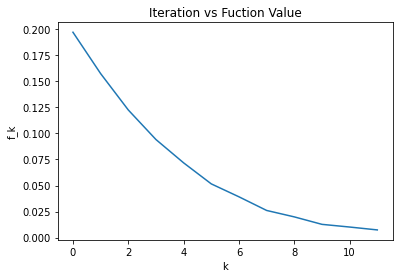

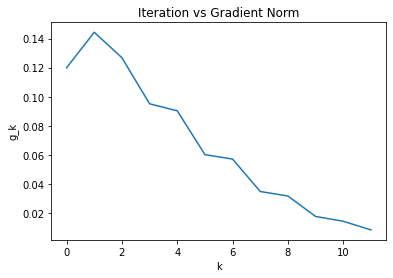

In [34]:
params = {'x_0'      : theta,
          'f'        : F,
          'f_grad'   : F_grad_aprox,
          'x'        : x_train,
          'y'        : y_train,
          'max_iter' : 30,
          'tau_grad' : 1e-2,
          'f_params' : {'x' : x_train,
                        'y' : y_train,
                        'N' : N, 
                        'n' : n, 
                        'm' : m,
                        'h' : 1e-4
                       }
          }

star = time.time()
f_hist, g_hist, x_star_sd = des_grad(params)
print ('Tiempo de ejecución: ', time.time() - star, 'segundos.')
get_graf(f_hist, g_hist)

## BFGS

In [56]:
from sklearn.datasets import make_spd_matrix
from sklearn.preprocessing import normalize

# Genero matriz definida positiva
H_0 = make_spd_matrix(theta.shape[0])

iteración:  1 Norma de gradiente:  0.11990252739719516
iteración:  2 Norma de gradiente:  0.09382155402325304
iteración:  3 Norma de gradiente:  0.080335419870916
iteración:  4 Norma de gradiente:  0.08198446330999822
iteración:  5 Norma de gradiente:  0.08911623829455324
iteración:  6 Norma de gradiente:  0.1022966492005774
iteración:  7 Norma de gradiente:  0.11594453986790912
iteración:  8 Norma de gradiente:  0.1209416067157759
iteración:  9 Norma de gradiente:  0.11345359373107324
iteración:  10 Norma de gradiente:  0.08976207470871111
iteración:  11 Norma de gradiente:  0.04266732790731231
iteración:  12 Norma de gradiente:  0.02766467455999537
iteración:  13 Norma de gradiente:  0.020114115024848528
iteración:  14 Norma de gradiente:  0.016486508987573225
iteración:  15 Norma de gradiente:  0.015099354052557542
iteración:  16 Norma de gradiente:  0.014369830687323084
iteración:  17 Norma de gradiente:  0.013814315262703863
iteración:  18 Norma de gradiente:  0.013183315970490397

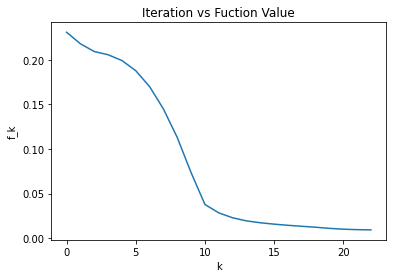

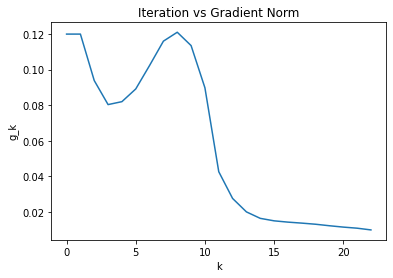

In [57]:
params = {'x_0'      : theta,
          'B_0'      : H_0,
          'f'        : F,
          'f_grad'   : F_grad_aprox,
          'x'        : x_train,
          'y'        : y_train,
          'max_iter' : 30,
          'tau_grad' : 1e-2,
          'f_params' : {'x' : x_train,
                        'y' : y_train,
                        'N' : N, 
                        'n' : n, 
                        'm' : m,
                        'h' : 1e-4
                       },
          'method'      : 'BackTracking',
          'BackTracking' : {'alpha' : 0.5,
                            'ro'    : 0.9,
                            'c1'    : 1e-4
                           }
          }

star = time.time()
f_hist, g_hist, x_star_bfgs = BFGS(params)
print ('Tiempo de ejecución: ', time.time() - star, 'segundos.')
get_graf(f_hist, g_hist)

# Error

Seleccionar del conjunto $test\_set[0]$ y $test\_set[1]$ el conjunto $\tau = \{ (x_i, y_i)\}$ tal que $x_i \in \mathbb{R}^{784}$ y $y_i \in \{0,1\}$ t calcule el error
$$ error = \dfrac{1}{|\tau|} \sum_{(x_i, y_i) \in \tau} | \textbf{1} _{h_{\theta} > 0.5 }(x_i) - y_i | $$

donde $|\tau|$ representa el número de elementos del conjunto $\tau$.

#### Error Descenso Gradiente

In [54]:
error(x_test, y_test, x_star_sd, n, m)

0.0037281323877068557

### Error BFGS

In [58]:
error(x_test, y_test, x_star_bfgs, n, m)

0.009929078014184398